In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%config InlineBackend.figure_format = 'retina'
from DS_detector import rematch_cat
from DS_models_stat import cut_cat

In [10]:
df = rematch_cat('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv', tp_dist=400/3600, add_fn=False)
#df = rematch_cat('/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.00.csv', tp_dist=400/3600)
name='SZcat(AL)'
df = cut_cat(df, dict_cut={'l' : [0, 180], 'b' : [20, np.inf]})

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
df = df[df['status'] != 'fp']
df = df[df['catalog'] != 'planck_no_z']
df.index = np.arange(len(df))

In [12]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
q_m = [df['M500'].quantile(i/10) for i in range(0, 11)]
q_m[0] = 0
q_m[-1] = 20

In [13]:
q_m500 = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_m500[en] = [cur_df['M500'].quantile(i / 10) for i in range(11)]
    q_m500[en][-1] = 20

In [14]:
q_m500 = pd.DataFrame(q_m500)
q_m500

,0.111667,0.188400,0.267000,0.357746,0.502287,2.000000
0,0.153200,0.621400,1.403068,1.200900,1.121300,1.420565
1,1.164050,1.663395,2.080533,2.110358,2.085918,2.025188
2,1.492765,2.239400,2.873207,2.457475,2.609184,2.515684
3,1.802464,2.678325,3.295155,3.204654,2.978987,2.830999
4,1.929044,2.977400,3.774467,4.034956,3.462629,3.218910
5,2.228490,3.258917,4.107262,4.461557,4.019432,3.652422
6,2.476900,3.544395,4.341394,4.924279,5.062408,4.749640
7,2.696856,3.911314,4.695724,5.497556,5.518576,5.421814
8,3.017628,4.334959,5.005952,5.915491,5.989572,6.315530
9,3.922967,5.209722,6.020343,6.768952,7.054101,6.979298


In [15]:
prm = 'max_pred'
pred_ind_mean = []
for j in range(len(q_m500[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        pred_ind = cur_df[prm].mean()
        if np.isnan(pred_ind):
            #print(cur_df[prm])
            print(z_st, z_en, m_st, m_en)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = pred_ind
    pred_ind_mean.append(pd.DataFrame(line, index=[j]))
pred_ind_mean = pd.concat(pred_ind_mean)

In [16]:
cm = sns.light_palette("green", as_cmap=True)

s = pred_ind_mean.style.background_gradient(cmap=cm)
s

,"(0.00,0.11)","(0.11,0.19)","(0.19,0.27)","(0.27,0.36)","(0.36,0.50)","(0.50,2.00)"
0,0.461318,0.469897,0.463957,0.370981,0.359716,0.289139
1,0.607049,0.509308,0.463339,0.398709,0.417299,0.282210
2,0.716620,0.649049,0.636116,0.559269,0.432040,0.350103
3,0.804918,0.785267,0.652225,0.604369,0.514068,0.391704
4,0.736988,0.665930,0.841138,0.731341,0.488263,0.447240
5,0.854910,0.725514,0.860595,0.786592,0.655506,0.414825
6,0.936024,0.806924,0.798845,0.911545,0.800133,0.510578
7,0.909107,0.837139,0.941512,0.849801,0.831484,0.710440
8,0.937695,0.968126,0.960939,0.929203,0.908548,0.862945
9,0.985628,0.990123,0.961585,0.990214,0.955930,0.926541


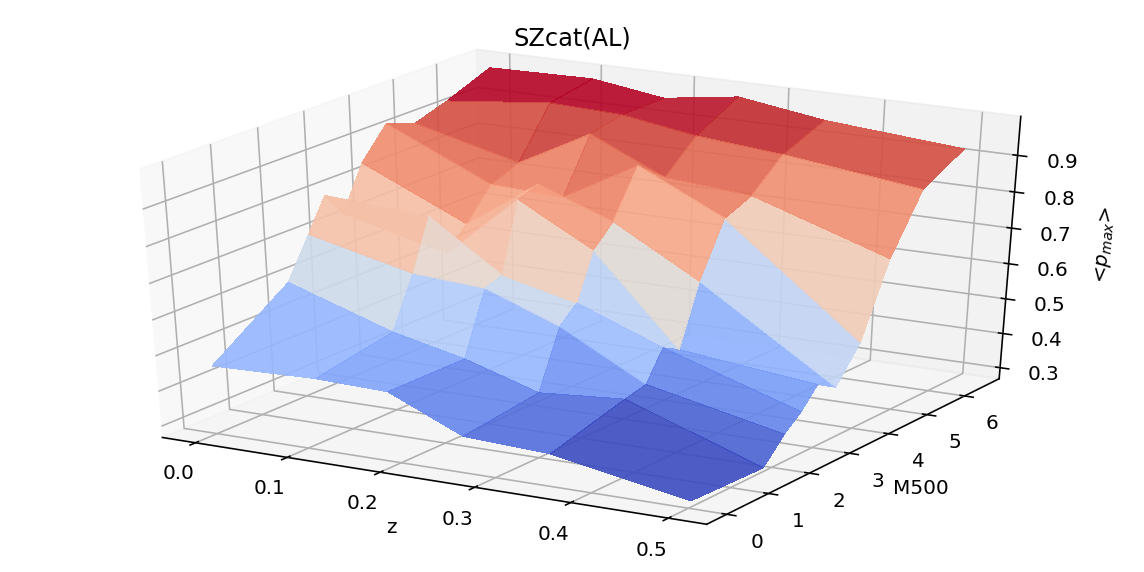

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(pred_ind_mean)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = pred_ind_mean[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_ylabel('M500')
ax.set_zlabel('<$p_{max}$>')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title(name)
plt.show()